In [3]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

In [4]:
from functools import partial


class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

In [ ]:
import pandas as pd

# Load data from CSV file
df = pd.read_csv('first_emission_50gev.csv')

print(f"Loaded {len(df)} events from first_emission_50gev.csv")
print(f"\nDataset columns: {list(df.columns)}")
print(df.head())

# Extract momentum data
pT_all = df['Particle_pT'].values
pz_data = df['Particle_pz'].values
E_data = df['Particle_E'].values

# Calculate pz' (rescaled pz with reference energy)
E_ref = 50.0  # Reference energy in GeV
pz_prime_all = E_ref * (pz_data / E_data)

print(f"\nData ranges:")
print(f"  pT range: [{pT_all.min():.3f}, {pT_all.max():.3f}] GeV/c")
print(f"  pz range: [{pz_data.min():.3f}, {pz_data.max():.3f}] GeV/c")
print(f"  pz' range: [{pz_prime_all.min():.3f}, {pz_prime_all.max():.3f}] GeV/c")
print(f"\nTotal samples: {len(pT_all)}")

size = __________

Loaded 10000 events from first_emission_50gev.csv

Dataset columns: ['Event', 'Name', 'Pid', 'Particle_px', 'Particle_py', 'Particle_pz', 'Particle_E', 'Particle_pT']
   Event Name  Pid  Particle_px  Particle_py  Particle_pz  Particle_E  \
0      0  pi0  111     0.160985     0.235890    36.980500   36.981800   
1      1  pi0  111     0.236153     0.365678    22.802300   22.806800   
2      2  pi- -211     0.072274     0.046684     0.632455    0.653362   
3      3  pi- -211     0.036291     0.250416    41.818200   41.819200   
4      4  pi0  111    -0.149215     0.046229     8.431800    8.434330   

   Particle_pT  
0     0.285588  
1     0.435303  
2     0.086040  
3     0.253032  
4     0.156212  

Data ranges:
  pT range: [0.002, 1.706] GeV/c
  pz range: [0.254, 49.526] GeV/c
  pz' range: [42.608, 50.000] GeV/c

Total samples: 10000


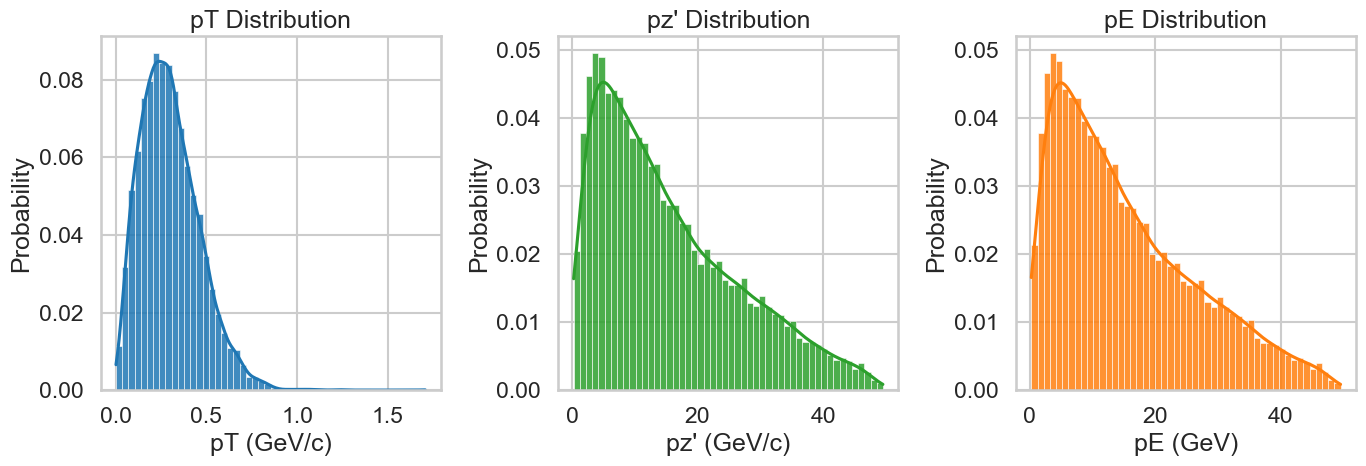

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seaborn style
sns.set_theme(style="whitegrid", context="talk")

# Plot histograms with KDE overlays for the momentum distributions
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

sns.histplot(pT_all, bins=50, stat="probability", kde=True, ax=axes[0],
             color="tab:blue", edgecolor=None, alpha=0.85)
axes[0].set_xlabel("pT (GeV/c)")
axes[0].set_ylabel("Probability")
axes[0].set_title("pT Distribution")

sns.histplot(pz_data, bins=50, stat="probability", kde=True, ax=axes[1],
             color="tab:green", edgecolor=None, alpha=0.85)
axes[1].set_xlabel("pz (GeV/c)")
axes[1].set_ylabel("Probability")
axes[1].set_title("pz Distribution")

sns.histplot(E_data, bins=50, stat="probability", kde=True, ax=axes[2],
             color="tab:orange", edgecolor=None, alpha=0.85)
axes[2].set_xlabel("pE (GeV)")
axes[2].set_ylabel("Probability")
axes[2].set_title("pE Distribution")

plt.tight_layout()
plt.show()

In [13]:
import pennylane as qml
from pennylane import numpy as np

np.random.seed(42)


n_qubits = size
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.probs()


jit_circuit = jax.jit(circuit)

NameError: name 'size' is not defined

In [19]:
import optax

bandwidth = jnp.array([0.25, 0.5, 1])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, probs)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

ModuleNotFoundError: No module named 'optax'

In [ ]:
loss_1, px = qcbm.mmd_loss(weights)  # squared MMD
loss_2 = mmd.k_expval(px, px) - 2 * mmd.k_expval(px, probs) + mmd.k_expval(probs, probs)
print(loss_1)
print(loss_2)

In [21]:
# Training

@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    log_ratio = jnp.where(qcbm.py == 0, 0, jnp.log(qcbm_probs / qcbm.py))

    kl_div = -jnp.sum(qcbm.py *  log_ratio)
    return params, opt_state, loss_val, kl_div


history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0222 KL-div: 0.8367
Step: 10 Loss: 0.0043 KL-div: 0.3321
Step: 20 Loss: 0.0021 KL-div: 0.2203
Step: 30 Loss: 0.0015 KL-div: 0.1644
Step: 40 Loss: 0.0011 KL-div: 0.1029
Step: 50 Loss: 0.0006 KL-div: 0.0544
Step: 60 Loss: 0.0003 KL-div: 0.0351
Step: 70 Loss: 0.0002 KL-div: 0.0232
Step: 80 Loss: 0.0002 KL-div: 0.0171
Step: 90 Loss: 0.0002 KL-div: 0.0138


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MMD Loss")

ax[1].plot(divs, color="green")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("KL Divergence")
plt.show()

In [ ]:
qcbm_probs = np.array(qcbm.circ(weights))

plt.figure(figsize=(12, 5))

plt.bar(
    np.arange(2**size),
    probs,
    width=2.0,
    label=r"$\pi(x)$",
    alpha=0.4,
    color="tab:blue",
)
plt.bar(
    np.arange(2**size),
    qcbm_probs,
    width=2.0,
    label=r"$p_\theta(x)$",
    alpha=0.9,
    color="tab:green",
)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.xticks(nums, bitstrings, rotation=80)
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

In [ ]:
# Testing

def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.sample()


for N in [2000, 20000]:
    dev = qml.device("default.qubit", wires=n_qubits)
    circ = qml.set_shots(qml.QNode(circuit, device=dev), shots = N)
    preds = circ(weights)
    mask = np.any(np.all(preds[:, None] == data, axis=2), axis=1)  # Check for row-wise equality
    chi = np.sum(mask) / N
    print(f"χ for N = {N}: {chi:.4f}")

print(f"χ for N = ∞: {np.sum(qcbm_probs[nums]):.4f}")

In [ ]:
plt.figure(figsize=(8, 8))
j = 1
for i, m in zip(preds[:64], mask[:64]):
    ax = plt.subplot(8, 8, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    if ~m:
        plt.setp(ax.spines.values(), color="red", linewidth=1.5)
    plt.xticks([])
    plt.yticks([])

# Tutorial

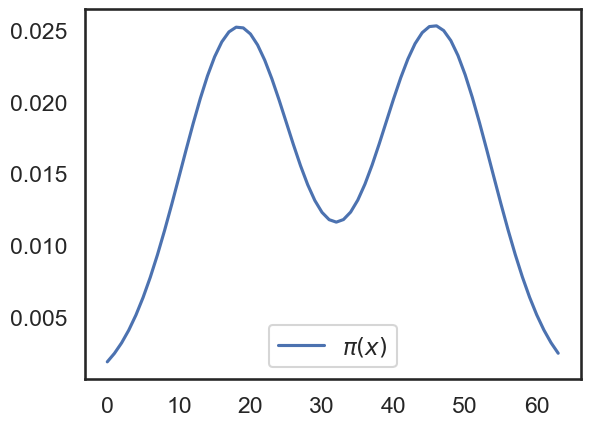

In [24]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(2 / 7) * x_max, (5 / 7) * x_max]
sigmas = [x_max / 8] * 2
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

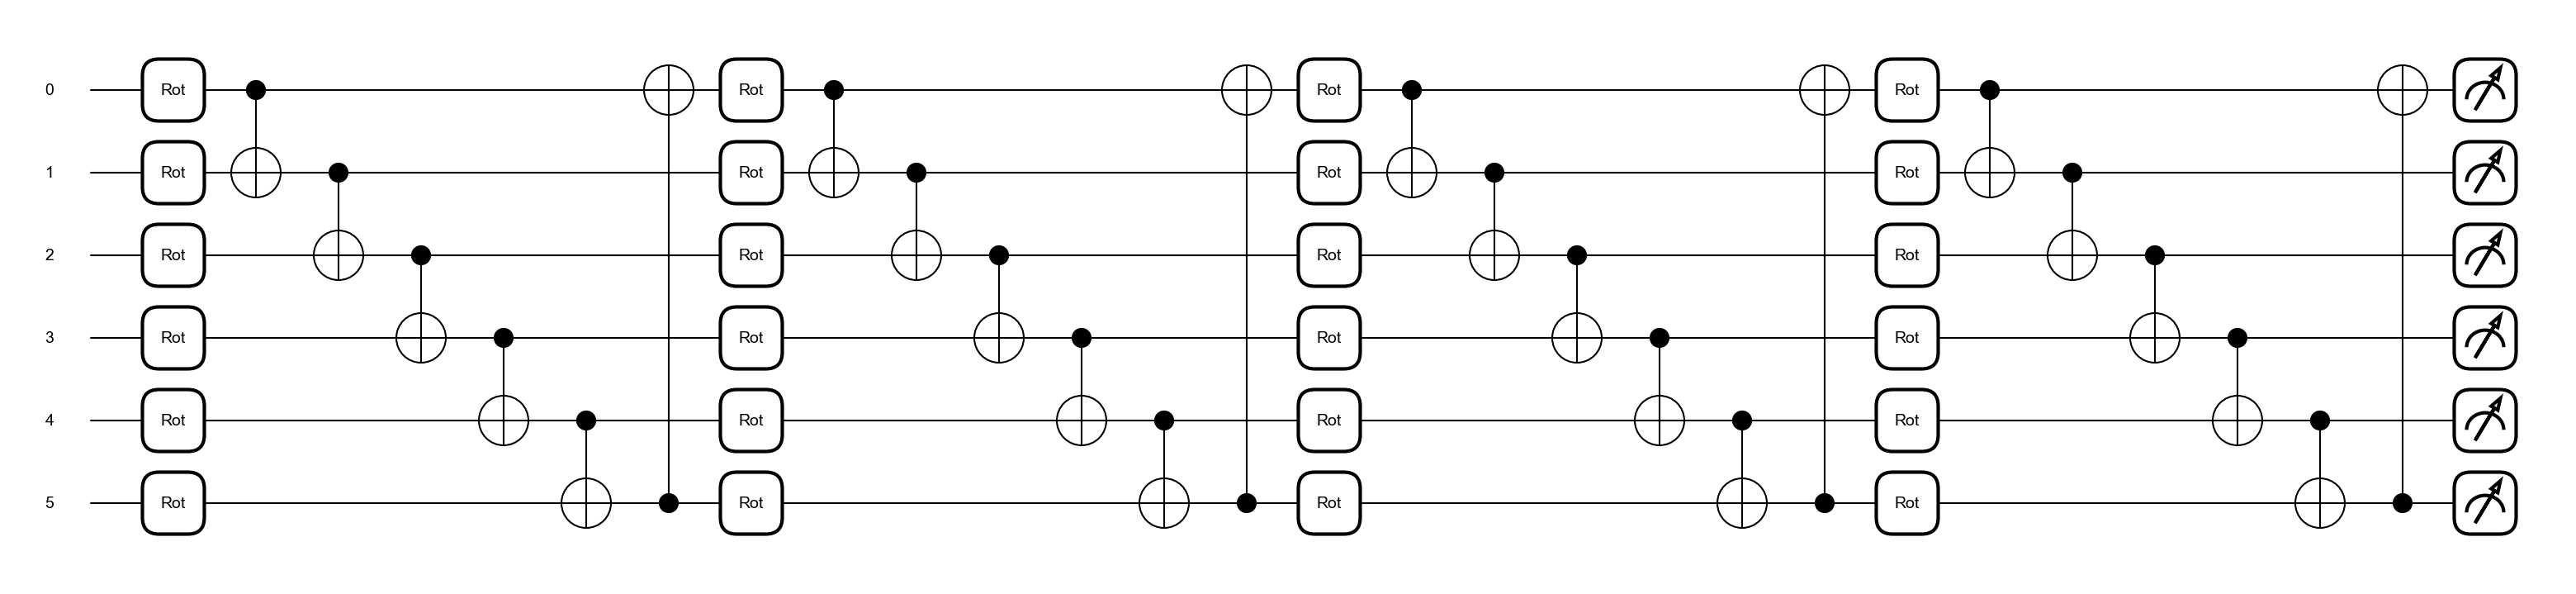

In [25]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


# @qml.set_shots(N)
@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [26]:
import optax

bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0216 KL-div: 1.0079
Step: 10 Loss: 0.0034 KL-div: 0.2839
Step: 20 Loss: 0.0019 KL-div: 0.2437
Step: 30 Loss: 0.0010 KL-div: 0.0891
Step: 40 Loss: 0.0008 KL-div: 0.0981
Step: 50 Loss: 0.0006 KL-div: 0.0584
Step: 60 Loss: 0.0003 KL-div: 0.0286
Step: 70 Loss: 0.0002 KL-div: 0.0179
Step: 80 Loss: 0.0001 KL-div: 0.0120
Step: 90 Loss: 0.0001 KL-div: 0.0083


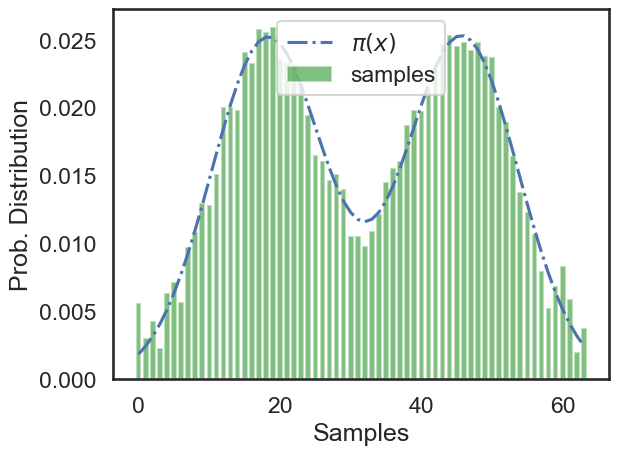

In [27]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()